# **Imports**

In [1]:
import ast
import datetime as dt
from fastai.vision.all import *

import gradio as gr

import io

import matplotlib.image as image
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
from numpy import array
from numpy import argmax

import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser

import pandas as pd

import pickle

from PIL import Image

from scipy.io import loadmat

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tarfile

import time

import torch
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, datasets, models
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.transforms import functional as F
%matplotlib inline

# **Use GPU**

In [2]:
''' Get available device, preferably GPU '''
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('Using device:', device)

Using device: cuda:0


# **Download stanford-dogs-dataset**

In [63]:
# open file
images_exists = exists('images.tar')

if images_exists:
    os.remove('images.tar')

# open file
images_exists = exists('./stanford-dogs-dataset/Images')

if images_exists:
    shutil.rmtree('./stanford-dogs-dataset/Images')

!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"

images_file = tarfile.open('images.tar')

# extract files
images_file.extractall('./stanford-dogs-dataset')

# close file
images_file.close()

--2025-07-06 20:42:50--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  20.0MB/s    in 48s     

2025-07-06 20:43:38 (15.8 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [64]:
!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar"

# open file
lists_file = tarfile.open('lists.tar')

# print file names
print(lists_file.getnames())

# extract files
lists_file.extractall('./stanford-dogs-dataset')

# close file
lists_file.close()

--2025-07-06 20:43:44--  http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481280 (470K) [application/x-tar]
Saving to: ‘lists.tar.1’

lists.tar.1         100%[===================>] 470.00K   317KB/s    in 1.5s    

2025-07-06 20:43:46 (317 KB/s) - ‘lists.tar.1’ saved [481280/481280]

['file_list.mat', 'train_list.mat', 'test_list.mat']


In [65]:
!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/train_data.mat"
!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/test_data.mat"

--2025-07-06 20:43:46--  http://vision.stanford.edu/aditya86/ImageNetDogs/train_data.mat
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1247551328 (1.2G) [text/plain]
Saving to: ‘train_data.mat.1’

train_data.mat.1    100%[===================>]   1.16G  18.3MB/s    in 74s     

2025-07-06 20:44:59 (16.2 MB/s) - ‘train_data.mat.1’ saved [1247551328/1247551328]

--2025-07-06 20:44:59--  http://vision.stanford.edu/aditya86/ImageNetDogs/test_data.mat
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 892614155 (851M) [text/plain]
Saving to: ‘test_data.mat.1’

test_data.mat.1     100%[===================>] 851.26M  19.9MB/s    in 47s     

2025-07-06 20:45:47 (18.0 MB/s) - ‘

#**Static variables**

In [66]:
# static variables
data_set_path = Path("/content/stanford-dogs-dataset/")

In [67]:
list(data_set_path.ls())

[Path('/content/stanford-dogs-dataset/Images'),
 Path('/content/stanford-dogs-dataset/file_list.mat'),
 Path('/content/stanford-dogs-dataset/train_list.mat'),
 Path('/content/stanford-dogs-dataset/test.csv'),
 Path('/content/stanford-dogs-dataset/test_list.mat'),
 Path('/content/stanford-dogs-dataset/train.csv')]

# **Create Labels list**

In [68]:
test_filenames = [o[0][0] for o in loadmat(data_set_path/'test_list.mat')['file_list']]
train_filenames = [o[0][0] for o in loadmat(data_set_path/'train_list.mat')['file_list']]

In [69]:
len(train_filenames), len(test_filenames)

(12000, 8580)

In [70]:
train_labels = L(train_filenames).map(lambda o: o.split("/")[0])

In [71]:
def one_hot_encode(labels, label_encoder=None):
    values = np.array(labels)

    # Use provided encoder or create a new one
    if label_encoder is None:
        label_encoder = LabelEncoder()
        label_encoder.fit(values)

    integer_encoded = label_encoder.transform(values)

    onehot_encoder = OneHotEncoder(sparse_output=False)
    col_vec_integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(col_vec_integer_encoded)

    onehot_encoded_list = [list(map(float, label)) for label in onehot_encoded]

    return integer_encoded, onehot_encoded_list, label_encoder

In [72]:
def reverse_encode(label_encoder, int_enc_label):
    return label_encoder.inverse_transform([int_enc_label])[0]

# **Create Train/Test data frames**

In [73]:
test_labels = L(test_filenames).map(lambda o: o.split("/")[0])

In [74]:
# First fit the encoder once on all labels (train + test)
all_labels = train_labels + test_labels
_, _, shared_encoder = one_hot_encode(all_labels)

# Now use the same encoder for both
int_enc_train_labels, train_labels_ohe, _ = one_hot_encode(train_labels, shared_encoder)
int_enc_test_labels, test_labels_ohe, _ = one_hot_encode(test_labels, shared_encoder)

In [75]:
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(shared_encoder, f)

In [76]:
# Create DataFrame
train_df = pd.DataFrame({"filenames": train_filenames, "labels": train_labels_ohe})

In [77]:
test_df = pd.DataFrame({"filenames":test_filenames, "labels": test_labels_ohe})

In [78]:
train_df.to_csv(data_set_path/"train.csv", index=False)
test_df.to_csv(data_set_path/"test.csv", index=False)

In [79]:
train_df.shape, test_df.shape

((12000, 2), (8580, 2))

# **Define StanfordDogsDataset**

In [80]:
class StanfordDogsDataset(Dataset):
    def __init__(self, labels, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = pd.read_csv(labels)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0]
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels_str = self.labels.iloc[idx, 1]
        labels = np.array(ast.literal_eval(labels_str)).astype('float')
        label = np.argmax(labels)

        if self.transform:
            image = self.transform(image)

        return [image, label]

In [81]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow((inp * 255).astype(np.uint8))

# **Create Train/Test data sets and data loaders**

In [82]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

train_trans = transforms.Compose([
    transforms.RandomResizedCrop(size=299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

test_trans = transforms.Compose([
    transforms.Resize(342),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    normalize
])

str_data_path = str(Path(data_set_path))

# creating train data set and data loader
train_labels_path = str_data_path + "/train.csv"
print(train_labels_path)
root_path = str_data_path + "/Images/"
print(root_path)

train_dogs_dataset = StanfordDogsDataset(labels = train_labels_path,
                                         root_dir = root_path, transform=train_trans)

print(len(train_dogs_dataset))

whole_train_dl = DataLoader(train_dogs_dataset,
                            batch_size=64, shuffle=True, num_workers=2)

print(len(whole_train_dl))

# creating test data set and data loader
test_labels_path = str_data_path + "/test.csv"
print(test_labels_path)
root_path = str_data_path + "/Images/"
print(root_path)

test_dogs_dataset = StanfordDogsDataset(labels = test_labels_path,
                                        root_dir = root_path, transform=test_trans)

print(len(test_dogs_dataset))

test_dl = DataLoader(test_dogs_dataset,
                    batch_size=64, shuffle=True, num_workers=2)
print(len(test_dl))

/content/stanford-dogs-dataset/train.csv
/content/stanford-dogs-dataset/Images/
12000
188
/content/stanford-dogs-dataset/test.csv
/content/stanford-dogs-dataset/Images/
8580
135


# **Visualize a batch of train's data loader**

64 64


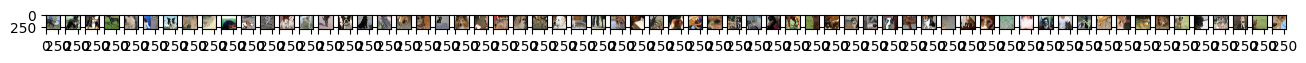

In [83]:
img, label = next(iter(whole_train_dl))
print(len(img), len(label))
fig = plt.figure(1, figsize=(16, 64))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 64), axes_pad=0.05)

for i in range(len(img)):
    ax = grid[i]
    imshow(ax, img[i])

In [84]:
np.random.seed(0)

# **Download pretrained models**

In [85]:
! mkdir -p pretrained-pytorch-models/

In [86]:
!ls pretrained-pytorch-models/

inception_v3_google-1a9a5a14.pth


In [87]:
cache_dir = expanduser(join('~', '.torch'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [88]:
!cp -r pretrained-pytorch-models/ ~/.torch/models/

In [89]:
!ls ~/.torch/models

pretrained-pytorch-models


In [90]:
!ls stanford-dogs-dataset

file_list.mat  Images  test.csv  test_list.mat	train.csv  train_list.mat


In [91]:
!wget -c "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth"

--2025-07-06 20:45:58--  https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth
Resolving download.pytorch.org (download.pytorch.org)... 18.239.83.69, 18.239.83.126, 18.239.83.32, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.239.83.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108857766 (104M) [application/octet-stream]
Saving to: ‘inception_v3_google-1a9a5a14.pth’

inception_v3_google 100%[===================>] 103.81M   163MB/s    in 0.6s    

2025-07-06 20:45:59 (163 MB/s) - ‘inception_v3_google-1a9a5a14.pth’ saved [108857766/108857766]



In [92]:
!mv inception_v3_google-1a9a5a14.pth pretrained-pytorch-models/inception_v3_google-1a9a5a14.pth

# **Define the model**

In [97]:
# Path to the uploaded model file on Kaggle
model_path = 'pretrained-pytorch-models/inception_v3_google-1a9a5a14.pth'

# Load the pretrained model
inception = models.inception_v3(weights=Inception_V3_Weights.DEFAULT)
inception.load_state_dict(torch.load(model_path))

# Freeze all model parameters
for param in inception.parameters():
    param.requires_grad = False

# New final layer with 16 classes (modify if needed)
num_ftrs = inception.fc.in_features
inception.fc = torch.nn.Linear(num_ftrs, 120)

# Move the model to GPU if available
inception = inception.to(device)

# **Training loop**

In [98]:
# Training function
def train_model(train_loader, test_loader, model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()
    lrs = []
    train_accs = []
    train_loss = []
    test_accs = []
    test_loss = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs, aux_outputs = model(inputs)
                loss = criterion(outputs, labels) + criterion(aux_outputs, labels)
                _, preds = torch.max(outputs, 1)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

         # Save the learning rate
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_loss.append(epoch_loss)
        train_accs.append(epoch_acc.cpu().numpy())
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = running_corrects.double() / len(test_loader.dataset)

        test_loss.append(epoch_loss)
        test_accs.append(epoch_acc.cpu().numpy())
        print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, lrs, train_loss, train_accs, test_loss, test_accs

# **Define Loss function, optimizer and lr_scheduler**

In [99]:
criterion = torch.nn.CrossEntropyLoss()

# Use named_parameters to get both the name and the parameter
bias_params = [p for name, p in inception.fc.named_parameters() if 'bias' in name]
others = [p for name, p in inception.fc.named_parameters() if 'bias' not in name]

# Create the optimizer with separate parameter groups
optimizer = torch.optim.Adam([
    {'params': others, 'weight_decay':1e-4},
    {'params': bias_params, 'weight_decay': 0}
], lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# **Training the model**

In [100]:
start_time = time.time()
model, lrs, train_loss, train_accs, test_loss, test_accs = train_model(whole_train_dl, test_dl, inception, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch 0/9
----------
Train Loss: 11.6473 Acc: 0.5287
Test Loss: 0.7223 Acc: 0.8683
Epoch 1/9
----------
Train Loss: 10.4329 Acc: 0.7045
Test Loss: 0.4969 Acc: 0.8760
Epoch 2/9
----------
Train Loss: 10.2879 Acc: 0.7220
Test Loss: 0.4262 Acc: 0.8878
Epoch 3/9
----------
Train Loss: 10.2187 Acc: 0.7298
Test Loss: 0.4160 Acc: 0.8814
Epoch 4/9
----------
Train Loss: 10.1801 Acc: 0.7414
Test Loss: 0.3830 Acc: 0.8854
Epoch 5/9
----------
Train Loss: 10.1407 Acc: 0.7479
Test Loss: 0.3692 Acc: 0.8937
Epoch 6/9
----------
Train Loss: 10.1102 Acc: 0.7538
Test Loss: 0.3620 Acc: 0.8903
Epoch 7/9
----------
Train Loss: 10.1076 Acc: 0.7577
Test Loss: 0.3716 Acc: 0.8895
Epoch 8/9
----------
Train Loss: 10.0952 Acc: 0.7564
Test Loss: 0.3609 Acc: 0.8913
Epoch 9/9
----------
Train Loss: 10.0735 Acc: 0.7624
Test Loss: 0.3529 Acc: 0.8900
Training complete in 22m 44s
Training time:  22.730917 minutes


In [102]:
torch.save(model.state_dict(), "model.pt")

# **Visualizations**

In [103]:
def plot_2_graphs(model_name, y_title, x_title, train_y, test_y):
    f1 = plt.figure()

    # plotting the points
    title = model_name + " - " + "Train" + " - " + y_title + " / " + x_title + " graph!"
    plt.plot(train_y, label = title)
    title = model_name + " - " + "Test" + " - " + y_title + " / " + x_title + " graph!"
    plt.plot(test_y, label = title)

    plt.legend()

    # function to show the plot
    plt.show()

def plot_graph(model_name, y_title, x_title, y):
    f2 = plt.figure()

    # plotting the points
    title = model_name + " - " + "Train" + " - " + y_title + " / " + x_title + " graph!"
    plt.plot(y, label = title)

    plt.legend()

    # function to show the plot
    plt.show()

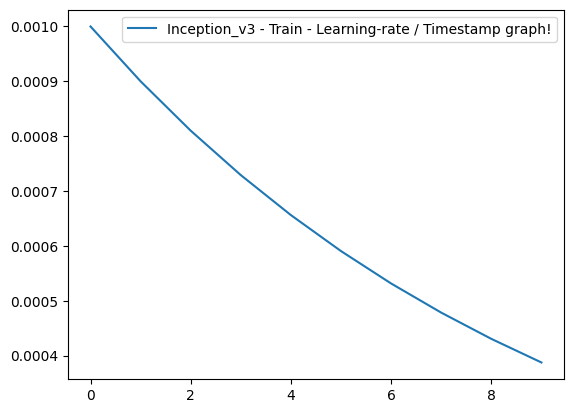

In [104]:
plot_graph("Inception_v3", "Learning-rate", "Timestamp", lrs)

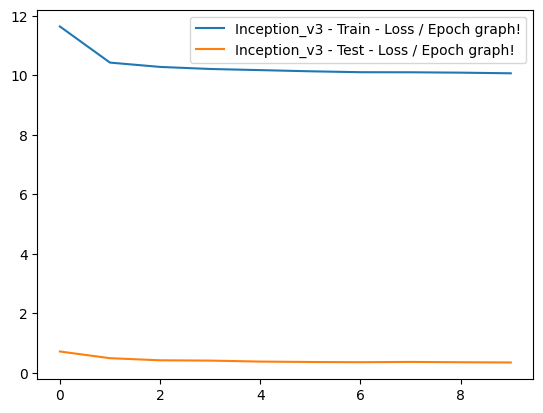

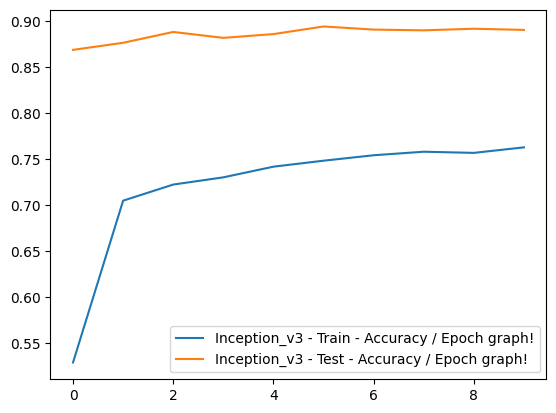

In [105]:
plot_2_graphs("Inception_v3", "Loss", "Epoch", train_loss, test_loss)
plot_2_graphs("Inception_v3", "Accuracy", "Epoch", train_accs, test_accs)

# **Test Loop**

In [106]:
def test_model(dataloader, model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward
        # Use only the main output in evaluation mode
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)

    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print()

    time_elapsed = time.time() - since
    print(f'Test complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return epoch_loss, epoch_acc

# **Testing the model**

In [107]:
start_time = time.time()
test_loss, test_acc = test_model(test_dl, model, criterion, optimizer, exp_lr_scheduler, num_epochs=1)
print('Test time: {:10f} minutes'.format((time.time()-start_time)/60))

Loss: 0.3529 Acc: 0.8900

Test complete in 1m 1s
Test time:   1.019983 minutes


# **Test Accuracy calculation**

In [108]:
print(f'Acc: {test_acc:.4f}')

Acc: 0.8900


# **visualize a single test example**

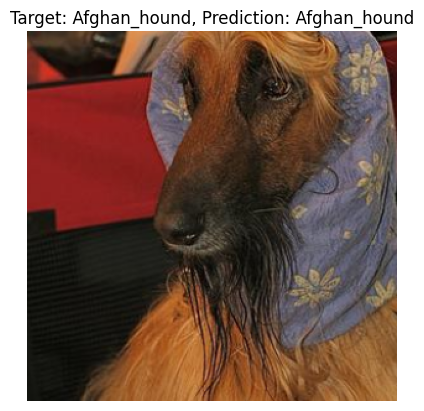

In [109]:
# Function to visualize a single test example
def visualize_test_example(dataloader, model):
    model.eval()

    with torch.no_grad():
        # Get a single batch from the dataloader
        inputs, labels = next(iter(dataloader))
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Get the first image and its label and prediction
        image_idx = 1
        input_img = inputs[image_idx].cpu()
        label = labels[image_idx].cpu().item()
        str_label = reverse_encode(shared_encoder, label)
        # Decode class label
        clean_label = str_label.split('-', 1)[1] if '-' in str_label else str_label
        pred = preds[image_idx].cpu().item()
        str_pred = reverse_encode(shared_encoder, pred)
        clean_pred = str_pred.split('-', 1)[1] if '-' in str_pred else str_pred

        # Denormalize the image for visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        input_img = input_img.permute(1, 2, 0).numpy() * std + mean
        input_img = np.clip(input_img, 0, 1)

        # Plot the image with target and prediction
        plt.imshow(input_img)
        plt.title(f'Target: {clean_label}, Prediction: {clean_pred}')
        plt.axis('off')
        plt.show()

visualize_test_example(test_dl, model)